# Introduction

A cool thing about hierarchical models is that its easy to predict out of sample - i.e. if you want to make a prediction on a new zipcode, just sample from the state's distribution (composed of the state average and variance across zip codes in that state)

In pymc3, it's somewhat easy to accomplish this, but not as straightforward as we'd hope. This blog post will show a trick that lets you easily predict out of sample, and will reduce some of the overhead that comes from writing alot of custom prediction functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import pymc3 as pm
import arviz as az
SEED = 99

# Simulating data
We'll simulate a 2 level hierarchical model - for interpretability, we'll set it up as a state > zipcode model

In [2]:
def gen_zipcode(size=1):
    '''Ugly way to generate fake zip codes'''
    codes = []
    for _ in range(int(2*size) + 10 ):
        code = ''
        for _ in range(5):
            code += np.random.choice(range(9)).astype(str)
        codes.append(code)
        
    return np.array(list(set(codes))[:size])


In [3]:
# Simulate data
np.random.seed(SEED)
N_states = 10
N_zips_per_state = 15

# Coefficients
mu_country_true = 0
sig_state_true = 5
mu_state_true = pm.Normal.dist(mu_country_true, sig_state_true)
states_true = mu_state_true.random(size=N_states)

sig_zip_true = 3
mu_zipcode_true = pm.Normal.dist(states_true, sig_zip_true)
zipcode_true = mu_zipcode_true.random(size=N_zips_per_state)

# Indexes for observed dataa
state_idx = np.random.choice(np.arange(N_states), size=1000)
zip_idx = np.random.choice(np.arange(N_zips_per_state), size=1000)

# observed data
sig_obs_true = 2
y_true = np.random.normal( zipcode_true[zip_idx, state_idx], sig_obs_true)

# Labels
states = np.sort(np.array(["CA", "TX", "FL", "GA", "AL", "ME", "MA", "CT", "NY", "NJ"]))
zip_codes = np.sort(gen_zipcode(N_states*N_zips_per_state))

In [4]:
# Change zipcode index to 0-1000 instead of 0-100 by 
# making these fake zipcodes nested within states
zip_idx_adj = (pd.Series( state_idx*N_zips_per_state + zip_idx ).astype("str") 
              ).astype(int).values

In [5]:
# organizing the data
df = (
    pd.DataFrame({
        "y":y_true,
        "state":states[state_idx],
        "zipcode":zip_codes[zip_idx_adj]
    })
)

df.head(10)

,y,state,zipcode
0,6.953332,ME,61756
1,8.789451,FL,28766
2,6.810024,FL,26505
3,7.922506,ME,63467
4,13.250428,CA,11450
5,-6.689709,AL,04463
6,-7.306024,TX,85822
7,-0.031004,CT,23215
8,0.307124,GA,40461
9,0.175902,GA,35720


## Using categorical variables for convenience

Categorical variables are a somewhat new feature of pandas - they can store categories that aren't in the observed data, and are an easy replacement for `pd.factorize()`

We can use these to trick pymc into thinking there's a category with no observed data, and pymc ends up assigning the global distribution to that unobserved category, which we can simply reference in the future for any time we want to make a prediction on out of sample data

In [6]:
# Convert to categorical and add a `global` category
df = df.assign(state = pd.Categorical(df.state).add_categories("out_of_sample"))\
    .assign(zipcode = pd.Categorical(df.zipcode).add_categories("out_of_sample"))

df.head()

,y,state,zipcode
0,6.953332,ME,61756
1,8.789451,FL,28766
2,6.810024,FL,26505
3,7.922506,ME,63467
4,13.250428,CA,11450


# Fitting the model

We'll use the `codes` from the categorical columns to index our model coefficients, and we'll use the `categories` as coordinates for the model to map names to

In [7]:
coords={
    "state":df.state.cat.categories,
    "zipcode":df.zipcode.cat.categories
}

# Peak at state labels
coords["state"]

Index(['AL', 'CA', 'CT', 'FL', 'GA', 'MA', 'ME', 'NJ', 'NY', 'TX',
       'out_of_sample'],
      dtype='object')

In [8]:
# # This model could have sampled more efficiently, commenting it out

# with pm.Model(coords=coords) as model:
    
#     # Hyperpriors
#     mu_country = pm.Normal("mu_country", 0, 3)
#     sig_country = pm.Exponential("sig_country", 2.5)
    
#     # priors
#     sig_zipcode = pm.Exponential("sig_zipcode", 1)
#     sig = pm.Exponential("sig", 1)
    
#     # Hierarchical coefficients
#     mu_state = pm.Normal("mu_state", mu_country, sig_country, dims="state")
#     mu_zipcode = pm.Normal("mu_zipcode", mu_state, sig_zipcode, dims=("zipcode", "state"))
    
#     # Observational model
#     y = pm.Normal("y", mu_zipcode[zip_, state_], sig, observed=df.y)
    
#     # Fit
#     trace = pm.sample(target_accept=0.9, return_inferencedata=True, random_seed=SEED)

The model above had some difficulties sampling, so we'll try a noncentered parameterization

In [9]:
def hierarchical_normal(name, μ, dims):
    '''Adapted from Austin Rochford'''
    Δ = pm.Normal('Δ_{}'.format(name), 0., 1., dims=dims)
    σ = pm.Exponential('σ_{}'.format(name), 2.5)
    return pm.Deterministic(name, μ + Δ * σ, dims=dims)


with pm.Model(coords=coords) as model_nc:
    
    # Observed Data tracking
    state_ = pm.Data("state_", df.state.cat.codes)
    zip_ = pm.Data("zip_", df.zipcode.cat.codes)
    obs = pm.Data("obs", df.y)

    # Hyperprior
    mu_country = pm.Normal("mu_country", 0, 1)
    
    # Prior
    sig = pm.Exponential("sig", 1)
    
    # Hierarchical coefficients
    mu_state = hierarchical_normal("mu_state", μ=mu_country, dims="state")
    mu_zipcode = hierarchical_normal("mu_zipcode", μ=mu_state, dims=("zipcode", "state") )
    
    # Observational model
    y = pm.Normal("y", mu_zipcode[zip_, state_], sig, observed=obs)
    
    # Fit 
    trace_nc = pm.sample(target_accept=0.9, return_inferencedata=True, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ_mu_zipcode, Δ_mu_zipcode, σ_mu_state, Δ_mu_state, sig, mu_country]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
The number of effective samples is smaller than 25% for some parameters.


Let's take a peak at at the state level coefficients

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

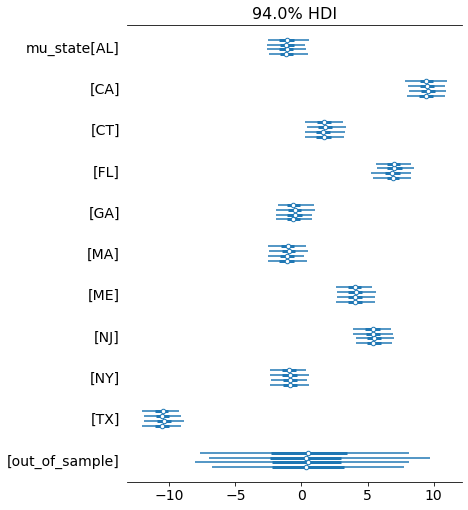

In [10]:
pm.plot_forest(trace_nc, var_names=["mu_state"])

Great, that `out of sample` variable seems to represent the global distribution across states - i.e. if we were to make a prediction for a new state we'd use that distribtion. We should still confirm it to be safe

We'll check for zip codes below as well, looking at Maine specifically

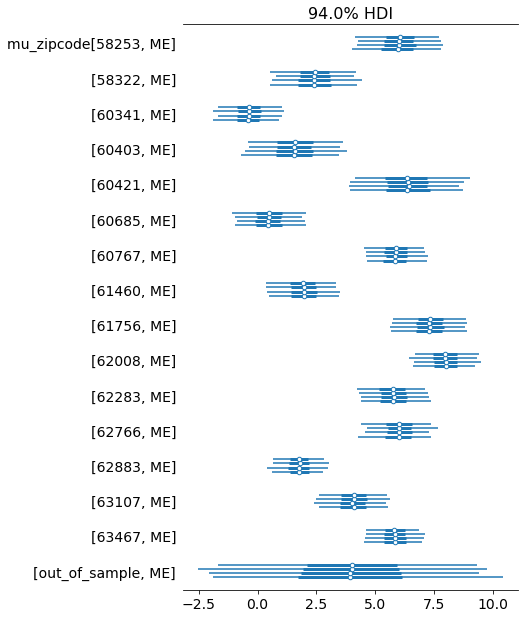

In [11]:
ME_zips = df.loc[lambda d: d.state=="ME"].zipcode.tolist() + ["out_of_sample"]
pm.plot_forest(trace_nc, var_names=["mu_zipcode"],
              coords={"state":["ME"], "zipcode":np.unique( ME_zips )});

As we can see, the `out_of_sample` variable has a sampled value despite there being no observed data for it

Now the question is, does this align with how we'd predict new data?

Let's try calculating coefficients out of sample by hand and see if it aligns with the `out_of_sample` values

In [12]:
post = trace_nc.posterior

# Calculate out of sample state means by drawing from global distribution
mu_country = post["mu_country"].values.reshape(4000,-1)
σ_state = post["σ_mu_state"].values.reshape(4000,-1)
mu_state = np.random.normal(mu_country, σ_state)

# calculate out of sample mu by drawing from out of sample state prediction above
σ_zipcode = post["σ_mu_zipcode"].values.reshape(4000,-1)
mu_zipcode = np.random.normal(mu_state, σ_zipcode)

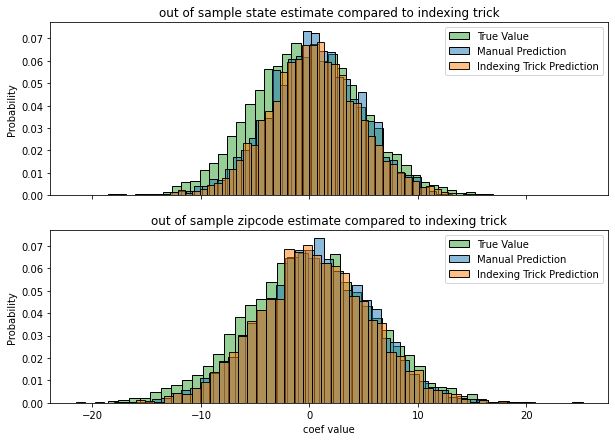

In [13]:
# Plot comparison
fig, ax = plt.subplots(2,1,figsize=(10,7),sharex=True)

# Plot 1
ax[0].set_title("out of sample state estimate compared to indexing trick")

# Ground truth
sns.histplot( mu_state_true.random(size=4000), 
             alpha=0.5, 
             color="C2",
             label="True Value",
             stat="probability",
            ax=ax[0])

# Manual calculation from fitted model
sns.histplot( mu_state.ravel(), 
             alpha=0.5, 
             label="Manual Prediction",
             stat="probability",
            ax=ax[0]);

# Indexing trick
sns.histplot( post["mu_state"].sel({"state":["out_of_sample"]}).values.ravel(), 
             alpha=0.5, 
             color="C1", 
             label="Indexing Trick Prediction",
             stat="probability",
            ax=ax[0])
ax[0].legend()


# Plot 2
ax[1].set_title("out of sample zipcode estimate compared to indexing trick")

# Ground truth
sns.histplot( pm.Normal.dist(mu_state_true.random(size=4000), sig_zip_true).random(size=4000), 
             alpha=0.5, 
             color="C2",
             label="True Value",
             stat="probability",
            ax=ax[1])

# Manual calculation from fitted model
sns.histplot( mu_zipcode.ravel(), 
             alpha=0.5, 
             label="Manual Prediction",
             stat="probability",
            ax=ax[1])

# Indexing trick
sns.histplot( post["mu_zipcode"].sel({"state":["out_of_sample"], "zipcode":["out_of_sample"]}).values.ravel(), 
             alpha=0.5, 
             color="C1", 
             label="Indexing Trick Prediction",
             stat="probability",
            ax=ax[1])
ax[1].legend()
ax[0].set_xlabel("coef value")
ax[1].set_xlabel("coef value")
plt.show()

As we can see above, the indexing trick recovers the true parameters - this can make prediction MUCH easier, especially if we change model paramaterization

# Predicting out of sample

Let's go ahead and actually make prediction now - we'll make predictions for the following data below
 * The first example is in sample
 * The second example is in sample for state, out of sample for zipcode
 * The third example is out of sample entirely

In [14]:
X = pd.DataFrame({
    "state":[df.iloc[0]["state"], "NY", "OH"],
    "zipcode":[df.iloc[0]["zipcode"], "10017", "30130"],
    "type":["in sample", "state in sample\nzipcode out of sample", "out of sample"]
})

X.iloc[:,:2]

,state,zipcode
0,ME,61756
1,NY,10017
2,OH,30130


We're making some quick convenience functions to map this new data to the proper indexes from the fitted model

In [15]:
# Helper functions
zip_lookup = dict(zip(df.zipcode.cat.categories, range(len(df.zipcode.cat.categories))))
state_lookup = dict(zip(df.state.cat.categories, range(len(df.state.cat.categories))))

def labels_to_index(series, lookup):
    '''Converts categories to their proper codes'''
    series = series.copy()
    in_sample = series.isin(lookup.keys())
    series.loc[~in_sample] = "out_of_sample"
    return series.map(lookup).values.astype("int8")

And finally we'll use the model to make predictions on this new data 

In [16]:
with model_nc:
    # Set new data for the model to make predictions on
    pm.set_data({
        "state_": X.state.pipe(labels_to_index, state_lookup),
        "zip_": X.zipcode.pipe(labels_to_index, zip_lookup)
    })
    
    # make predictions
    preds = pm.sample_posterior_predictive(trace_nc)

Text(0.5, 0, 'mu_zipcode')

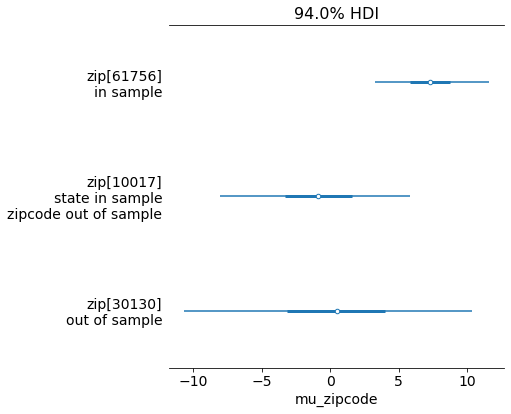

In [17]:
# Rearrange predictions to make plot more readable
pred_dct = {}
for i in range(len(X)):
    zipc = X.iloc[i]["zipcode"]
    name = X.iloc[i]["type"]
    pred_dct[f"zip[{zipc}]\n"+name] = preds["y"].T[i]

# Plot predictions
pm.plot_forest(pred_dct)
plt.xlabel("mu_zipcode", fontsize=14)

Notice how in sample predictions have smaller uncertainty intervals - this is great, its now much easier to make predictions compared to having to write out a custom prediction function that follows the same logic as the model